<a href="https://colab.research.google.com/github/Guowu-Mcgill/jaxwell/blob/main/Jaxwell_QuickStart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Check to see what GPU we have.
!nvidia-smi

Sat Nov 21 10:11:31 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0    30W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
# Install Jaxwell from github.
!pip install git+https://github.com/Guowu-Mcgill/jaxwell.git

  Cloning https://github.com/Guowu-Mcgill/jaxwell.git to /tmp/pip-req-build-iqnhtv7i
  Running command git clone -q https://github.com/Guowu-Mcgill/jaxwell.git /tmp/pip-req-build-iqnhtv7i
  Created wheel for jaxwell: filename=jaxwell-0.1-cp36-none-any.whl size=17717 sha256=dff82aa06c5dd16a14b10f67c51dc83bf0d051b43938b6fbe7df48ff3e7b1003
  Stored in directory: /tmp/pip-ephem-wheel-cache-ekmk_mjx/wheels/5a/f3/69/c1f3140ab284524daaba2324a312633f2f8f1ab8361c28541d
Successfully built jaxwell


In [9]:
# This is needed to enable JAX's double-precision mode, see 
# https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html#Double-(64bit)-precision
# for additional info.
from jax.config import config
config.update("jax_enable_x64", True)

from IPython.display import clear_output
import jax.numpy as np
import jaxwell
import matplotlib.pyplot as plt
import numpy as onp

# Check to make sure double-precision is enabled.
assert np.zeros((1,), np.float64).dtype == np.float64

In [10]:
test_s = onp.zeros((1, 1, 120, 120, 60), onp.complex128)
jaxwell.test_for_colab(test_s)

AttributeError: ignored

# New Section

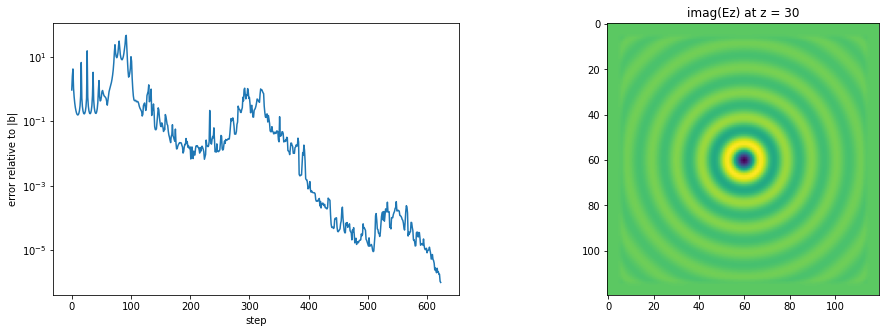

CPU times: user 31.4 s, sys: 11.9 s, total: 43.3 s
Wall time: 45 s


In [ ]:
# Simulate, monitoring progress

def monitor_fn(x, errs):
  '''Monitor progress by plotting error and `imag(Ez)`.'''
  clear_output(wait=True)
  plt.figure(figsize=(16, 5))
  plt.subplot(1, 2, 1)
  plt.xlabel('step')
  plt.ylabel('error relative to |b|')
  plt.semilogy(errs)
  plt.subplot(1, 2, 2)
  ind = x[2].shape[-1] // 2
  plt.title('imag(Ez) at z = {}'.format(ind))
  plt.imshow(x[2][0, 0, :, :, ind].imag)
  plt.show()

def point_source_sim(shape, max_iters):
  '''Solve a point source at λ=1550nm in silicon.'''
  dx = 40
  wavelength = 1550 / dx 
  omega = 2 * onp.pi / wavelength
  epsilon = 12.25
  w_eff = omega * onp.sqrt(epsilon)
  b_zero = onp.zeros(shape, onp.complex128)
  b = onp.zeros(shape, onp.complex128)
  b[0, 0, shape[2] // 2, shape[3] // 2, shape[4] // 2] = 1.
  b = jaxwell.vecfield.VecField(b_zero, b_zero, b).as_array()
  z = jaxwell.vecfield.VecField(*(w_eff**2 * np.ones(shape, np.complex128) for _ in range(3)))
  return jaxwell.solve(z, 
                       b, 
                       ths=((10, 10),) * 3,
                       pml_params=jaxwell.operators.PmlParams(w_eff=w_eff),
                       eps=1e-6,
                       max_iters=max_iters,
                       monitor_fn=monitor_fn,
                       monitor_every_n=25)

%time x, errs = point_source_sim((1, 1, 120, 120, 60), 10000)